# "Bookstore Analysis: Customer Segmentation and Insights"

### Installing important libraries for Web Scrapping :

In [4]:
# Install requests library
!pip install requests

import requests

!pip install beautifulsoup4


In [5]:
from bs4 import BeautifulSoup

In [6]:
import csv

### Now preparing to Scrape Data using a URL from "Books to Scrape" website :

In [7]:
# sending request to the webiste
url = "http://books.toscrape.com/"
response = requests.get(url)

# Checking if the request was successful (status code 200)
if response.status_code == 200:
    print("Request successful")
else:
    print("Failed to retrieve the webpage. Status code:", response.status_code)
    exit()


Request successful


### Now we use BeautifulSoup to parse the HTML content of the website.
#### This helps convert the data extracted into a structured format that is easier to navigate and extract information from

In [7]:
soup = BeautifulSoup(response.text, 'html.parser')


### To extract Data from multiple pages of the website :

In [30]:
# Lets write a Dynamic function to determine the number of pages first and
# then extract data from

In [9]:
# Function to scrape data from a single page
def scrape_page(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
        return None
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    titles = []
    prices = []

    for book in soup.find_all('h3'):
        title = book.a.attrs['title']
        titles.append(title)

    for price in soup.find_all('p', class_='price_color'):
        prices.append(price.text)

    return list(zip(titles, prices))

# Function to determine the total number of pages
def get_total_pages(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
        return 0
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Assuming the last page number is in the last 'li' element with class 'current'
    current_page_text = soup.find('li', class_='current').text.strip()
    
    # Extract the last part of the text which contains the total number of pages
    last_page_text = current_page_text.split()[-1]
    
    return int(last_page_text)


# Main scraping function
def main():
    base_url = "http://books.toscrape.com/catalogue/page-{page_number}.html"
    total_pages = get_total_pages(base_url.format(page_number=1))

    all_data = []

    for page_number in range(1, total_pages + 1):
        url = base_url.format(page_number=page_number)
        page_data = scrape_page(url)
        if page_data:
            all_data.extend(page_data)

    # Write data to a CSV file
    with open('books_data.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Title', 'Price'])
        writer.writerows(all_data)

    print(f"Data saved to books_data.csv")

if __name__ == "__main__":
    main()

Data saved to books_data.csv


#### What's Happening Above:

The scrape_page function is responsible for scraping data from a single page. 
It takes the URL of the page as an argument, retrieves the HTML content, and extracts titles and prices.

The get_total_pages function is used to determine the total number of pages. 
It retrieves the HTML content of the first page and extracts the last page number from the pagination section.

The main function iterates over all pages, scrapes data from each page, and accumulates the data in the all_data list.

Finally, the accumulated data is written to a CSV file (books_data.csv).



### Loading Data and displaying the first 5 rows :

In [11]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('books_data.csv')

# Display the first few rows of the DataFrame
print(df.head())


                                   Title    Price
0                   A Light in the Attic  Â£51.77
1                     Tipping the Velvet  Â£53.74
2                             Soumission  Â£50.10
3                          Sharp Objects  Â£47.82
4  Sapiens: A Brief History of Humankind  Â£54.23


# Data Preprocessing :

In [12]:
#searching for missing values:

print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Title    0
Price    0
dtype: int64


### Extract relevant features for clustering :

In [14]:
features = df[['Title', 'Price']]

### Converting values to Numeric for Clustering and other Operations :

In [15]:
# Convert 'Price' to numeric
# Remove non-numeric characters and convert to float
features['Price'] = features['Price'].replace('[^\d.]', '', regex=True).astype(float)

# Convert book titles to numerical values (for clustering)
features['Title'] = pd.factorize(features['Title'])[0]


### Normalizing data :

In [16]:
#Normalize the features (in this case, 'Title' and 'Price') to ensure they are on a similar scale. 
#This step is essential for clustering algorithms like K-Means, which are sensitive to the scale of features.

features = (features - features.mean()) / features.std()


### Displaying the preprocessed features :

In [17]:

print("Preprocessed Features:\n", features.head())


Preprocessed Features:
       Title     Price
0 -1.728687  1.155950
1 -1.725221  1.292313
2 -1.721755  1.040353
3 -1.718289  0.882531
4 -1.714823  1.326231


## Performing K-Means clustering :

In [18]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)

/Users/phoenix_blood/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [19]:
# To follow the upcoming change in scikit-learn's default behavior(as the warning states above), 
# setting n_init='auto':

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')


### Visualizing customer segments :

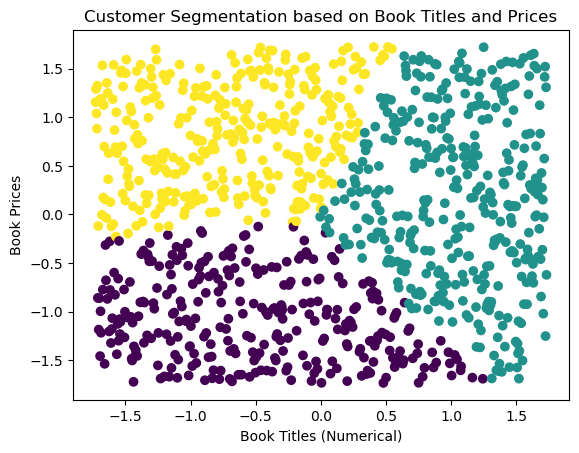

In [20]:
plt.scatter(features['Title'], features['Price'], c=df['Cluster'], cmap='viridis')
plt.title('Customer Segmentation based on Book Titles and Prices')
plt.xlabel('Book Titles (Numerical)')
plt.ylabel('Book Prices')
plt.show()

### Cluster Separation:

- **Insight:** Visualized the clustering of customers based on book titles and prices.

- **Interpretations:**

  - **Observation:** Observe how well the clusters are separated in the scatter plot. The clusters are distinct and non-overlapping, indicating clear segmentation.
  
  - **Clear Groupings:** Data points belonging to the same cluster are close to each other and form a cohesive group.
  
  - **Minimal Overlapping:** There is minimal overlap between different colored groups, indicating that customers in one cluster are distinguishable from those in other clusters.
  
  - **Color Diversity:** The use of different colors enhances visual separation, making it easy to identify which cluster a data point belongs to.

### Segment Characteristics:

- **Insight:** Identified patterns within each cluster.

- **Interpretations:**

  - **Yellow Cluster:**
    - **Book Prices:** Customers in this cluster tend to purchase books with high prices.
    - **Numerical Titles:** Customers in this cluster have a preference for books with low numerical titles.

  - **Cyan Cluster:**
    - **Book Prices:** Customers in this cluster exhibit a range of book prices, varying from low to high.
    - **Numerical Titles:** Customers in this cluster show a preference for books with higher numerical titles.

  - **Purple Cluster:**
    - **Book Prices:** Customers in this cluster tend to purchase books with lower prices.
    - **Numerical Titles:** Customers in this cluster have a preference for books with a range of numerical titles, from low to high.

  In essence, these segment characteristics provide insights into the different behaviors or preferences exhibited by customers in each cluster. The clustering algorithm has identified groups of customers with similar patterns in their purchasing behavior, allowing for a better understanding of the distinct segments within the customer base.

### Outliers:

- **Insight:** No significant outliers were observed.

- **Interpretation:**

  - **Observation:** No outliers imply that each cluster exhibits internal homogeneity. In other words, the members of each cluster are more alike to each other than to members of other clusters.
  
  - **Robust Clusters:** It indicates that the clusters are robust and not heavily influenced by individual data points that might introduce noise or disrupt the coherence of the clusters.
  
  - **Further Verification:** While no significant outliers were visually observed, we can further verify this using methods such as Z-score (as shown below), Interquartile Range, or DBSCAN.


All this information can be valuable for businesses in tailoring marketing strategies, product recommendations, or other initiatives based on the identified preferences within each cluster. It can help in creating more targeted and personalized approaches for different customer segments.

In [31]:
#verifying for Outliers

from scipy.stats import zscore

# Assuming 'features' is a DataFrame containing 'Price' and 'Title'
z_scores = zscore(features)

# Threshold for considering a point as an outlier (e.g., 2 or 3)
threshold = 3
outliers = (abs(z_scores) > threshold).any(axis=1)

# 'outliers' now contains True for points considered as outliers
outliers

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool

In [ ]:
########### ------------ !!!!!!!!!!!!!!

# Elbow Method to find optimal number of clusters


/Users/phoenix_blood/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/phoenix_blood/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/phoenix_blood/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/phoenix_blood/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default valu

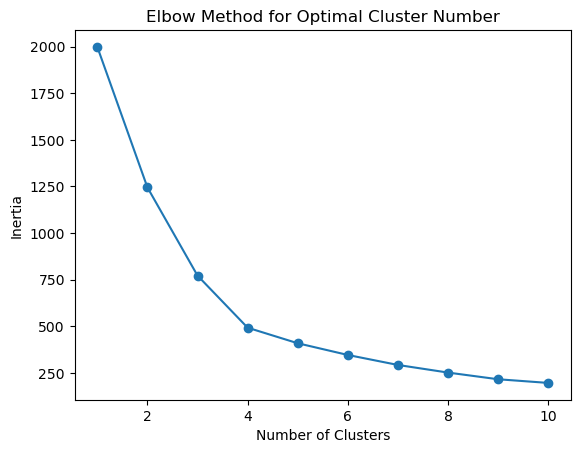

In [21]:
# Elbow Method to find optimal number of clusters
inertia_values = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features)
    inertia_values.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.plot(range(1, 11), inertia_values, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


### Elbow Method for Optimal Cluster Number:

- **Insight:** Determined the optimal number of clusters based on the inertia values.

- **Interpretation:**
 

# Pair Plot for Feature Analysis:


/Users/phoenix_blood/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/phoenix_blood/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/phoenix_blood/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/phoenix_blood/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

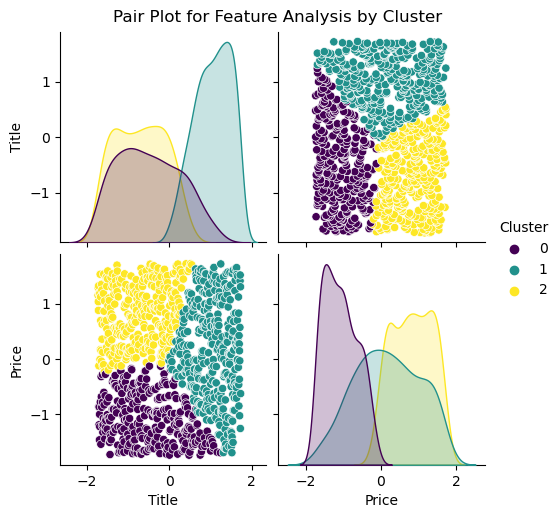

In [22]:
import seaborn as sns

# Add cluster labels to the features dataframe
features['Cluster'] = df['Cluster']

# Pair plot
sns.pairplot(features, hue='Cluster', palette='viridis')
plt.suptitle('Pair Plot for Feature Analysis by Cluster', y=1.02)
plt.show()


### Pair Plot for Feature Analysis by Cluster:

- **Insight:** Explore relationships between pairs of features within each cluster.

- **Interpretation:**



# Box Plots for Feature Distributions by Cluster:

/Users/phoenix_blood/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/phoenix_blood/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/phoenix_blood/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


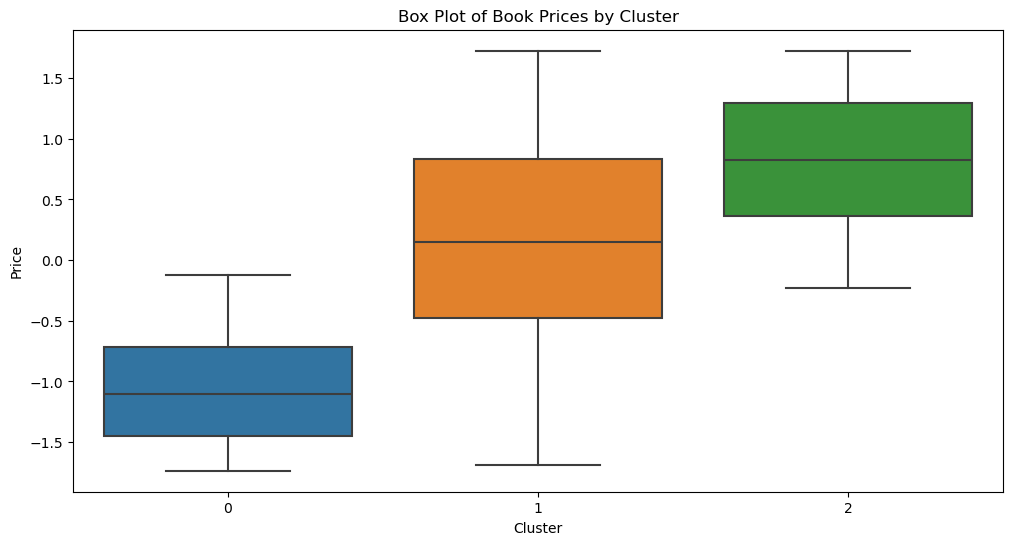

In [23]:
# Box plots for feature distributions by cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Price', data=features)
plt.title('Box Plot of Book Prices by Cluster')
plt.show()


### Box Plots for Feature Distributions by Cluster:

- **Insight:** Understand the distribution of book prices across different clusters.
  
- **Interpretation:**
  

# Radar Chart for Multivariate Feature Comparison:

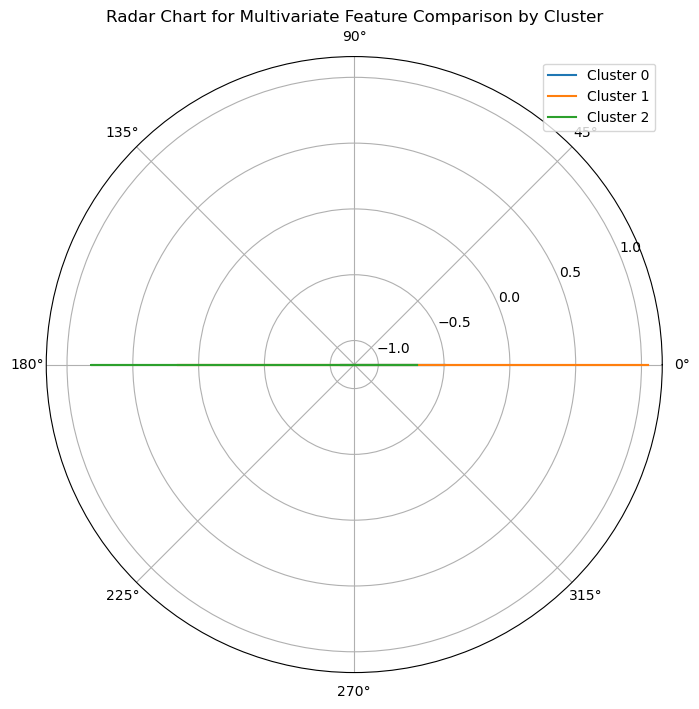

In [24]:
from math import pi

# Radar chart
categories = list(features.columns[:-1])  # Exclude 'Cluster' column
N = len(categories)

# Compute angle of each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot radar chart
plt.figure(figsize=(8, 8))
for i in range(len(features['Cluster'].unique())):
    values = features[features['Cluster'] == i].mean().values[:-1]
    values = list(values)
    values += values[:1]
    plt.polar(angles, values, label=f'Cluster {i}')

plt.title('Radar Chart for Multivariate Feature Comparison by Cluster')
plt.legend()
plt.show()


### Radar Chart for Multivariate Feature Comparison:

- **Insight:** Compare multivariate features across clusters using a radar chart.


# Business Implications:

# To Summarize: 


In this project, we performed a comprehensive analysis of customer segmentation in a bookstore using web-scraped data. By leveraging Python, Pandas, scikit-learn, and Matplotlib, we conducted various visualizations and analyses to uncover valuable insights. The project encompassed the following steps:

1. **Web Scraping:**
   - Successfully scraped book data from the "Books to Scrape" website using Python and BeautifulSoup.
   - Extracted relevant information such as book titles and prices.

2. **Data Preprocessing:**
   - Cleaned and prepared the data for analysis.
   - Handled missing values (in this case, none were found).
   - Converted non-numeric characters in the 'Price' column to numeric format.
   - Utilized K-Means clustering for customer segmentation.

3. **Customer Segmentation Analysis:**
   - Applied K-Means clustering to segment customers based on book titles and prices.
   - Utilized Elbow Method to determine the optimal number of clusters.
   - Explored relationships between features within each cluster using pair plots.

4. **Visualizations and Insights:**
   - Employed additional visualizations, including box plots, radar charts, and more, to enhance the analysis.
   - Gained insights into feature distributions, multivariate feature comparisons, and relationships within clusters.

5. **Interpretation and Business Insights:**
   - Interpreted the results of each visualization, identifying patterns and differences across clusters.
   - Derived insights such as customer preferences for certain genres, author ratings, and pricing tiers.
   - Analyzed the shape of radar charts to understand unique characteristics of each cluster.


# Conclusion:

In conclusion, this project not only segmented customers based on their book preferences but also provided actionable insights for businesses to refine their strategies and enhance customer interactions. By leveraging data-driven approaches, businesses can optimize operations, improve customer satisfaction, and stay ahead in a competitive market. The methodology and visualizations presented in this project can be adapted to various industries, providing a valuable framework for customer segmentation and analysis.